# Imports

In [ ]:
#Our implantations 
from diy_lib.decision_tree import Decision_tree
from diy_lib.node import Node
from diy_lib.nnlib import network
from diy_lib.nnlib import adiff

# Standard math lib
import pandas as pd
from typing import List
from itertools import combinations
from collections import Counter
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

#For decision tree
import sklearn as skl
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV 

#For random forest
from sklearn.ensemble import RandomForestClassifier

#For neural network
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

#For SMOTE
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

#For score calculation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support



# Load in the data sets

In [ ]:
test=pd.read_csv("../data/df_test.csv")
train=pd.read_csv("../data/df_train.csv")

# SMOTE

In [ ]:
trainY, trainX = train['type'], train.loc[:, train.columns != 'type']

sm = SMOTE(random_state = 42, sampling_strategy = 'not majority')

da = Counter(trainY)

# All classed have now equal number of observations
X_res, y_res = sm.fit_resample(trainX, trainY)

In [ ]:
#For our classifiers
train_res = pd.DataFrame(X_res)
train_res['type'] = y_res.tolist()

y_res, X_res = train_res['type'], train_res.loc[:, train_res.columns != 'type']

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


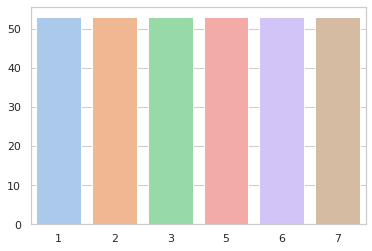

In [ ]:
sns.set_theme(style="whitegrid", palette="pastel")
x = Counter(train_res['type'])
sns.barplot(list(x.keys()), list(x.values()))
plt.savefig('after_typebar.png')

# Decision Tree

Accuracy: 0.6461538461538462
Recall: 0.6180124223602484
F1-Score: 0.5822192513368983


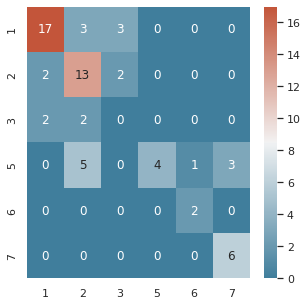

In [ ]:
T = Decision_tree(depth = 3, min_samples_split = 15) 
T.fit(train_res)
T.score_matix(test)
T.evaluation(test)

### For k-fold grid search for our own classifier

In [ ]:
def k_fold(data, sets):
    np.random.seed(42)
    data_dict = {}
    for s in range(sets):
        data = shuffle(data)
        test = pd.DataFrame()
        train = pd.DataFrame()
        for c in set(data['type']):
            class_c = data.loc[data['type'] == c]
            test_c = class_c.head(int(len(class_c)*(0.7)))
            train_c = class_c.iloc[len(test_c):]
            test = pd.concat([test, test_c])
            train = pd.concat([train, train_c])
        data_dict[s] = train, test
    return data_dict


def grid_k_fold(data, depths, samples, num_fold):
    cross_list = []
    dic = k_fold(data, num_fold)
    for depth in depths:
        hall_of_fame = []
        for sample in samples:
            best = 0
            for sets in range(num_fold):
                train, test = dic[sets]
                T = Decision_tree(depth = depth, min_samples_split = sample)
                x = T.fit(train)
                score = T.score(test)
                best += score
            hall_of_fame.append(best/num_fold)
        cross_list.append(hall_of_fame)
    return pd.DataFrame(cross_list)

In [ ]:
d = [2,3,5,8,9,10,12,15]
s = [2,4,6,8,10,15]

grid = grid_k_fold(train, d, s, 3) #(row = depth, column = min sample split)

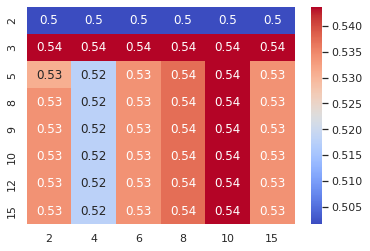

In [ ]:
sns.heatmap(grid, annot = True, cmap= "coolwarm", xticklabels = s, yticklabels = d) 
#x-axis = sample, y-axis = depth
plt.savefig('DT_grid_k_fold.png')

Accuracy: 0.6461538461538462
Recall: 0.6180124223602484
F1-Score: 0.5822192513368983


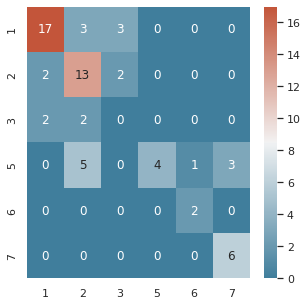

In [ ]:
T = Decision_tree(depth = 3, min_samples_split = 2)
T.fit(train_res) #oversample
T.score_matix(test)
T.evaluation(test)

In [ ]:
for id, node in T.tree.items():
    print(node.get_info(), '\n')

ID: 0 
Parent: None 
Children: [1, 2]
Most_common_class: 2 
Feature: Mg 
Threshold: 2.7050375836345317 
Gini: 0.6936445147679325 
Depth: 0 
Position: root
Amount of Datapoints: 318
Classes of Datapoints: Counter({2: 53, 1: 53, 5: 53, 7: 53, 6: 53, 3: 53}) 

ID: 1 
Parent: 0 
Children: [3, 4]
Most_common_class: 5 
Feature: Na 
Threshold: 14.047239987351594 
Gini: 0.4027136115250869 
Depth: 1 
Position: node at depth 1
Amount of Datapoints: 160
Classes of Datapoints: Counter({5: 53, 6: 53, 7: 46, 2: 8}) 

ID: 2 
Parent: 0 
Children: [9, 10]
Most_common_class: 1 
Feature: Ca 
Threshold: 8.424866777046503 
Gini: 0.5876109202476529 
Depth: 1 
Position: node at depth 1
Amount of Datapoints: 158
Classes of Datapoints: Counter({1: 53, 3: 53, 2: 45, 7: 7}) 

ID: 3 
Parent: 1 
Children: [5, 6]
Most_common_class: 5 
Feature: RI 
Threshold: 1.5265841209230766 
Gini: 0.09426229508196722 
Depth: 2 
Position: node at depth 2
Amount of Datapoints: 61
Classes of Datapoints: Counter({5: 53, 2: 7, 6: 1})

## Sklearn Decision Tree

In [ ]:
# With same hyperparameters
rDT = DecisionTreeClassifier(criterion='gini', 
                             splitter='best', 
                             max_depth=3, 
                             min_samples_split=2,   
                             random_state= 42)

rDT.fit(X_res, y_res)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [ ]:
y_pred = rDT.predict(test.loc[:, test.columns != 'type'])
y_true = test['type']


precision, recall, fscore, supporty = precision_recall_fscore_support(y_true, y_pred, average='macro')
acc = skl.metrics.accuracy_score(y_true, y_pred)

print('recall:', recall,
'F1-Score:', fscore,
'Accuracy:', acc)

recall: 0.6325051759834368 F1-Score: 0.6033910533910533 Accuracy: 0.676923076923077


### Sklearn Decision Tree optimized

In [ ]:
model = Pipeline([
        ('sampling', SMOTE(random_state = 42)),
        ('classification', DecisionTreeClassifier(random_state=43))])

parameters = {'classification__criterion': ['gini', 'entropy'],
              'classification__max_depth': [2,3,4,5,6,7,8,9,10,15,20,25],
              'classification__min_samples_split': [2,4,6,8,10,12,14],
              'sampling__sampling_strategy': ['not majority'],
              'sampling__k_neighbors': [1]}

op_dt = GridSearchCV(model, parameters)
op_dt.get_params().keys()
trainY, trainX = train['type'], train.loc[:, train.columns != 'type']
op_dt.fit(trainX, trainY)

GridSearchCV(estimator=Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                                       ('classification',
                                        DecisionTreeClassifier(random_state=43))]),
             param_grid={'classification__criterion': ['gini', 'entropy'],
                         'classification__max_depth': [2, 3, 4, 5, 6, 7, 8, 9,
                                                       10, 15, 20, 25],
                         'classification__min_samples_split': [2, 4, 6, 8, 10,
                                                               12, 14],
                         'sampling__k_neighbors': [1],
                         'sampling__sampling_strategy': ['not majority']})

In [ ]:
op_dt.best_params_

{'classification__criterion': 'entropy',
 'classification__max_depth': 6,
 'classification__min_samples_split': 8,
 'sampling__k_neighbors': 1,
 'sampling__sampling_strategy': 'not majority'}

In [ ]:
op_dt = DecisionTreeClassifier(criterion='gini', 
                             splitter='best', 
                             max_depth=6, 
                             min_samples_split=8,   
                             random_state= 42)
op_dt.fit(X_res, y_res)

DecisionTreeClassifier(max_depth=6, min_samples_split=8, random_state=42)

In [ ]:
y_pred = op_dt.predict(test.loc[:, test.columns != 'type'])
y_true = test['type']

precision, recall, fscore, supporty = precision_recall_fscore_support(y_true, y_pred, average='macro')
acc = skl.metrics.accuracy_score(y_true, y_pred)

print('Accuracy:', acc, 'recall:', recall,
'F1-Score:', fscore)

Accuracy: 0.6307692307692307 recall: 0.6479813664596273 F1-Score: 0.5941923929728808


# Neural Network

In [ ]:
#Three nerouns since the model is slow
def preprocess(data):#relables,normalises,shuffles and splits data into X and y 
    norm = StandardScaler()
    ros = RandomOverSampler(random_state=0)
    mapping={1:1,2:2,3:3,5:4,6:5,7:6}##changes y to be usable in loss funciton
    y=data.loc[:, data.columns == "type"]
    y=np.ravel(y)
    y=np.array([mapping[i]for i in y])
    X=data.loc[:, data.columns != "type"]
    X = norm.fit_transform(X)
    X, y = ros.fit_resample(X, y)
    X=[[adiff(float(j)) for j in i] for i in X]
    X,y=shuffle(X,y)
    return(X,y)

testingthing = network([3],activate = "sigmoid",alpha=0.015,gd="batch", batch_s=10,epochs=200)
X,y = preprocess(train)
testingthing.fit(X, y)

100%|██████████| 200/200 [30:25<00:00,  9.13s/it]


In [ ]:
X_test,y_true =preprocess(test)
y_pred = testingthing.predict(X_test)

In [ ]:
precision, recall, fscore, supporty = precision_recall_fscore_support(y_true, y_pred, average='macro')
acc = skl.metrics.accuracy_score(y_true, y_pred)
print('recall:', recall,
'F1-Score:', fscore,
'Accuracy:', acc)

recall: 0.16666666666666666 F1-Score: 0.047619047619047616 Accuracy: 0.16666666666666666
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


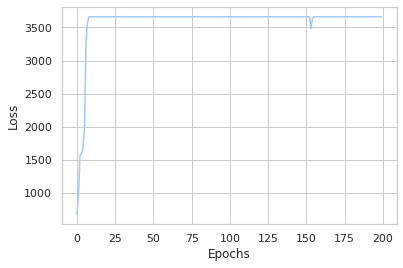

In [ ]:
plt.plot([i for i in range(len(testingthing.losses))],testingthing.losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig('crazy-plot.png')

## Sklearn Neural Network

In [ ]:
NN = MLPClassifier(solver='sgd', alpha=1e-7,
                   activation = 'relu',
                   hidden_layer_sizes=(30,35,30), 
                   random_state=1,
                   max_iter = 100000)

NN.fit(X_res, y_res)
y_pred = NN.predict(test.loc[:, test.columns != 'type'])
y_true = test['type']

In [ ]:
precision, recall, fscore, supporty = precision_recall_fscore_support(y_true, y_pred, average='macro')
acc = skl.metrics.accuracy_score(y_true, y_pred)
print('recall:', recall,
'F1-Score:', fscore,
'Accuracy:', acc)

recall: 0.5624568668046929 F1-Score: 0.5037037037037037 Accuracy: 0.5384615384615384
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Sklearn Neural Network optimized

In [ ]:
model = Pipeline([
        ('sampling', SMOTE(random_state = 42)),
        ('estimator',MLPClassifier(random_state=42))])

parameters = {'estimator__solver': ['sgd', 'adam'],
              'estimator__activation': ['logistic', 'tanh', 'relu'],
              'estimator__hidden_layer_sizes': [(30,35,30), (30,35,30,30), (15,20,20,15,20), (50,50,50), (20,25,20,24)], 
              'estimator__alpha': [1e-5, 1e-6, 1e-7],
              'sampling__sampling_strategy': ['not majority'],
              'sampling__k_neighbors': [1]}

op_NN = GridSearchCV(model, parameters)
op_NN.get_params().keys()

trainY, trainX = train['type'], train.loc[:, train.columns != 'type']

op_NN.fit(trainX, trainY)

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/shared-

GridSearchCV(estimator=Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                                       ('estimator',
                                        MLPClassifier(random_state=42))]),
             param_grid={'estimator__activation': ['logistic', 'tanh', 'relu'],
                         'estimator__alpha': [1e-05, 1e-06, 1e-07],
                         'estimator__hidden_layer_sizes': [(30, 35, 30),
                                                           (30, 35, 30, 30),
                                                           (15, 20, 20, 15, 20),
                                                           (50, 50, 50),
                                                           (20, 25, 20, 24)],
                         'estimator__solver': ['sgd', 'adam'],
                         'sampling__k_neighbors': [1],
                         'sampling__sampling_strategy': ['not majority']})

In [ ]:
op_NN.best_params_

{'estimator__activation': 'tanh',
 'estimator__alpha': 1e-05,
 'estimator__hidden_layer_sizes': (30, 35, 30, 30),
 'estimator__solver': 'adam',
 'sampling__k_neighbors': 1,
 'sampling__sampling_strategy': 'not majority'}

In [ ]:
op_NN = MLPClassifier(activation = 'tanh',
                      alpha = 1e-05,
                      hidden_layer_sizes = (30, 35, 30, 30),
                      solver =  'adam',
                      random_state = 42,
                      max_iter = 100000)
op_NN.fit(X_res, y_res)

MLPClassifier(activation='tanh', alpha=1e-05,
              hidden_layer_sizes=(30, 35, 30, 30), max_iter=100000,
              random_state=42)

In [ ]:
y_true = test['type']
y_pre = op_NN.predict(test.loc[:, test.columns != 'type'])

precision, recall, fscore, supporty = precision_recall_fscore_support(y_true, y_pre, average='macro')
acc = skl.metrics.accuracy_score(y_true, y_pre)

print('recall:', recall,
'F1-Score:', fscore,
'Accuracy:', acc)

recall: 0.7770818955601563 F1-Score: 0.7076398260608787 Accuracy: 0.6923076923076923


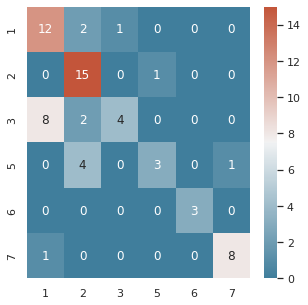

In [ ]:
list_of_classes = test['type'].tolist()
matrix = confusion_matrix(y_pre, test['type'].tolist())
fig, ax = plt.subplots(figsize=(5,5))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(matrix, annot=True, xticklabels = set(list_of_classes), yticklabels = set(list_of_classes), cmap = cmap)
plt.savefig('NN_Score_matrix.png')

# Random Forest

In [ ]:
RF = RandomForestClassifier(n_estimators=100,
                            criterion = 'gini', 
                            max_depth = 5, 
                            min_samples_split = 2,
                            bootstrap = True)

RF.fit(X_res, y_res)

RandomForestClassifier(max_depth=5)

In [ ]:
y_pred = RF.predict(test.loc[:, test.columns != 'type'])

In [ ]:
precision, recall, fscore, supporty = precision_recall_fscore_support(y_true, y_pred, average='macro')
acc = skl.metrics.accuracy_score(y_true, y_pred)
print('recall:', recall,
'F1-Score:', fscore,
'Accuracy:', acc)

recall: 0.7544053370140326 F1-Score: 0.6944291819291819 Accuracy: 0.7538461538461538


In [ ]:
model = Pipeline([
        ('sampling', SMOTE(random_state = 42)),
        ('classification', RandomForestClassifier(random_state=42))])

parameters = {'classification__criterion': ['gini', 'entropy'],
              'classification__max_depth':[2,3,5,6,8,10,12,14,15],
              'classification__min_samples_split': [2,4,6,8,10,12,14],
              'classification__bootstrap': [True],
              'classification__n_estimators':[10,20,30,40,50,60,70,80,90,100],
              'sampling__sampling_strategy': ['not majority'],
              'sampling__k_neighbors': [1]}

op_dt = GridSearchCV(model, parameters)
trainY, trainX = train['type'], train.loc[:, train.columns != 'type']
op_dt.fit(trainX, trainY)

GridSearchCV(estimator=Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                                       ('classification',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'classification__bootstrap': [True],
                         'classification__criterion': ['gini', 'entropy'],
                         'classification__max_depth': [2, 3, 5, 6, 8, 10, 12,
                                                       14, 15],
                         'classification__min_samples_split': [2, 4, 6, 8, 10,
                                                               12, 14],
                         'classification__n_estimators': [10, 20, 30, 40, 50,
                                                          60, 70, 80, 90, 100],
                         'sampling__k_neighbors': [1],
                         'sampling__sampling_strategy': ['not majority']})

In [ ]:
op_dt.best_params_

{'classification__bootstrap': True,
 'classification__criterion': 'gini',
 'classification__max_depth': 10,
 'classification__min_samples_split': 4,
 'classification__n_estimators': 70,
 'sampling__k_neighbors': 1,
 'sampling__sampling_strategy': 'not majority'}

In [ ]:
op_rf = RandomForestClassifier(n_estimators = 70,
                               criterion = 'gini', 
                               max_depth = 10, 
                               min_samples_split = 4,
                               bootstrap = True,
                               random_state = 42)
op_rf.fit(X_res, y_res)

RandomForestClassifier(max_depth=10, min_samples_split=4, n_estimators=70,
                       random_state=42)

In [ ]:
y_pred = op_rf.predict(test.loc[:, test.columns != 'type'])

In [ ]:
precision, recall, fscore, supporty = precision_recall_fscore_support(y_true, y_pred, average='macro')
acc = skl.metrics.accuracy_score(y_true, y_pred)

print('Accuracy:', acc, 'recall:', recall,
'F1-Score:', fscore)

Accuracy: 0.7846153846153846 recall: 0.768898090637221 F1-Score: 0.7053192450251274


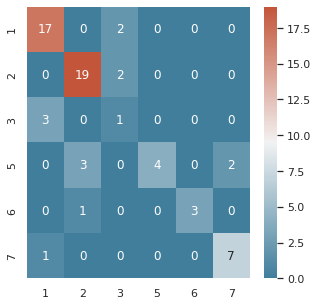

In [ ]:
list_of_classes = test['type'].tolist()
matrix = confusion_matrix(y_pred, test['type'].tolist())
fig, ax = plt.subplots(figsize=(5,5))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(matrix, annot=True, xticklabels = set(list_of_classes), yticklabels = set(list_of_classes), cmap = cmap)
plt.savefig('RF_Score_matrix.png')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=58866f15-1cff-4fef-9525-5c3070562370' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>